# Regret bounds

---

Imports

In [1]:
%load_ext autoreload
%autoreload 2

from typing import List
from typing import Callable

import pandas as pd
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from cost_structures import CostStructure
from non_perishable_inventory_state import NonPerishableInventoryState

from policies.abstract_inventory_policy import AbstractInventoryPolicy
from policies.my_algorithm import MyAlgorithm

experiment_name="new_algorithm"

Inventory state initialization

In [2]:
nb_products = 1
lead_times = np.zeros(nb_products,dtype=int)
state = NonPerishableInventoryState(nb_products,lead_times,"LOST_SALES")

Costs initialization

In [3]:
fixed_costs = np.zeros(nb_products)
purchase_costs = np.zeros(nb_products)
holding_costs = np.ones(1)
stockout_costs = np.ones(1)
cost_structure = CostStructure(nb_products,fixed_costs,purchase_costs,holding_costs,stockout_costs)
print("fixed_costs:{}\npurchase_costs:{}\nholding_costs:{}\nstockout_costs:{}".format(fixed_costs, purchase_costs, holding_costs, stockout_costs))

fixed_costs:[0.]
purchase_costs:[0.]
holding_costs:[1.]
stockout_costs:[1.]


In [15]:
policies : List[AbstractInventoryPolicy] =  [
    MyAlgorithm([1.5], [1],[2], 1/2 ,cost_structure),
]

Running the simulations

In [16]:
nb_periods = 10_000
demands_series = np.array(pd.read_csv("demand_series/demands_1",index_col=0))

for policy_id in tqdm(range(len(policies))) : 
    state.reset()
    cost_structure.reset()
    for t in tqdm(range(1,nb_periods+1)) :
        order_quantities = policies[policy_id].get_order_quantity(t,state)
        demands = demands_series[t-1]
        state.step(t,order_quantities, demands)
        cost_structure.incur_cost(t,state,order_quantities)
    cost_structure.save_history_as_csv("{}/costs_{}.csv".format(experiment_name,policy_id))
    state.save_movements_as_csv("{}/movements_{}.csv".format(experiment_name,policy_id))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

# Results

### Best performing methods

In [17]:
total_cost = np.zeros(len(policies))
for policy_id in range(len(policies)) :
    total_cost[policy_id] = pd.read_csv("cost_histories/{}/costs_{}.csv".format(experiment_name,policy_id))[["holding_cost","stockout_cost"]].sum().sum()/nb_periods
sorted_policies = np.argsort(total_cost)
for i in range(len(policies)) :
    print("{}. {} : {}".format(i+1, str(policies[sorted_policies[i]]), total_cost[sorted_policies[i]]))

1. My Algorithm : 5.032056210447351


### Average cost
$$
T\mapsto \frac{1}{T}\sum_{t=1}^T c(y_t,d_t)
$$

/var/folders/w6/qnfy53vx38z4f62nwwt31fr40000gn/T/ipykernel_48662/2090188875.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pd.read_csv("cost_histories/{}/costs_{}.csv".format(experiment_name,policy_id))


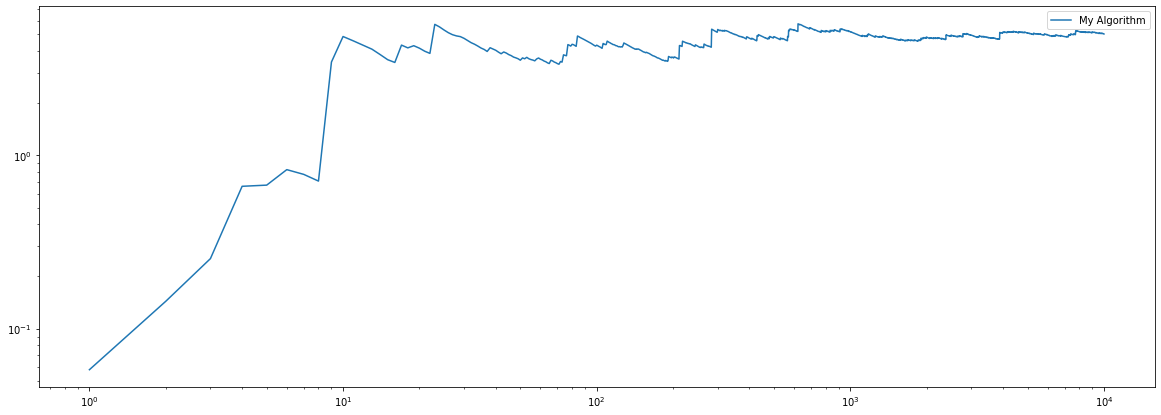

In [18]:
plt.figure(figsize=(20,7))
for policy_id in range(len(policies)) :
    x_ = np.arange(1,nb_periods+1)
    y_ = np.array(
        pd.read_csv("cost_histories/{}/costs_{}.csv".format(experiment_name,policy_id))
        .groupby("period")
        ["holding_cost","stockout_cost"]
        .sum()
        .sum(axis=1)
        .expanding()
        .mean()
    )
    plt.loglog(x_,y_,label=str(policies[policy_id]))
    #if(str(policies[policy_id]) == "OptimalStrategy") :
    #    band_ = 20/np.sqrt(x_)
    #    plt.fill_between(x_,np.maximum(0,y_-band_),y_+band_,alpha=0.15,color='red')
plt.legend()
plt.show()

### Average regret compared to $S^*$
$$
T\mapsto \frac{1}{T}\sum_{t=1}^T c(y_t,d_t)-c(S^*,d_t)
$$

/var/folders/w6/qnfy53vx38z4f62nwwt31fr40000gn/T/ipykernel_14960/4101962631.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pd.read_csv("cost_histories/{}/costs_{}.csv".format(experiment_name,3))
/var/folders/w6/qnfy53vx38z4f62nwwt31fr40000gn/T/ipykernel_14960/4101962631.py:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pd.read_csv("cost_histories/{}/costs_{}.csv".format(experiment_name,policy_id))
/var/folders/w6/qnfy53vx38z4f62nwwt31fr40000gn/T/ipykernel_14960/4101962631.py:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pd.read_csv("cost_histories/{}/costs_{}.csv".format(experiment_name,policy_id))
/var/folders/w6/qnfy53vx38z4f62nwwt31fr40000gn/T/ipykernel_14960/4101962631.py:19: FutureWarning: Indexing with multiple keys (implicitly c

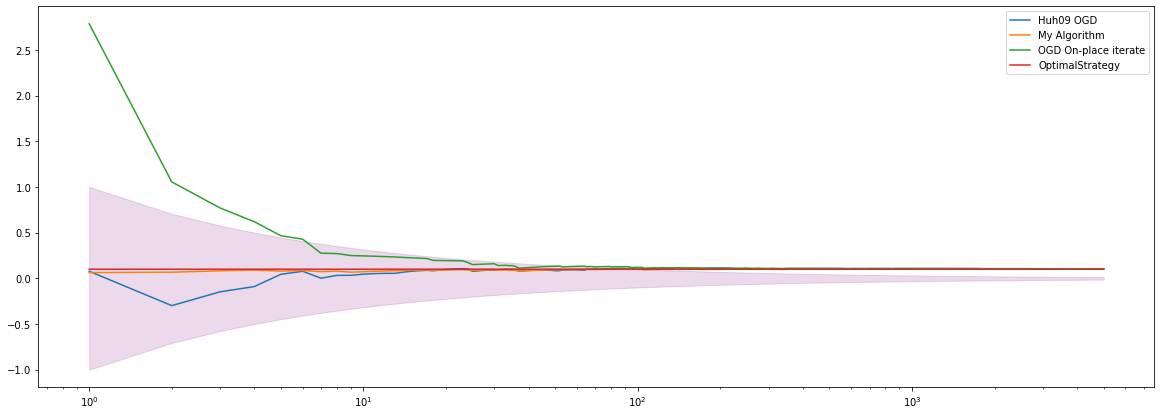

In [ ]:
opt_ = np.array(
        pd.read_csv("cost_histories/{}/costs_{}.csv".format(experiment_name,3))
        .groupby("period")
        ["holding_cost","stockout_cost"]
        .sum()
        .sum(axis=1)
        .expanding()
        .mean()
    )
plt.figure(figsize=(20,7))
for policy_id in range(len(policies)) :
    x_ = np.arange(1,nb_periods+1)

    if(str(policies[policy_id]) == "OptimalStrategy") :
        band_ = 1/np.sqrt(x_)
        plt.fill_between(x_,-band_,band_,alpha=0.15,color='purple',label="")

    y_ = np.array(
        pd.read_csv("cost_histories/{}/costs_{}.csv".format(experiment_name,policy_id))
        .groupby("period")
        ["holding_cost","stockout_cost"]
        .sum()
        .sum(axis=1)
        .expanding()
        .mean()
    )
    plt.semilogx(x_,y_-opt_+0.1,label=str(policies[policy_id]))
plt.legend()
plt.show()

### Average of expected costs
$$
T\mapsto \frac{1}{T}\sum_{t=1}^T \mathbb{E}_{\tilde{d}} [c(y_t,\tilde{d})] = \frac{1}{T}\sum_{t=1}^T Q(y_t)
$$

In [ ]:
def expected_instantaneous_cost(y:np.array) :
    return holding_costs[0]*(y-demand_upper_bound/2) + ( (holding_costs[0]+stockout_costs[0])/demand_upper_bound ) * (np.power(demand_upper_bound-y,2)/2)

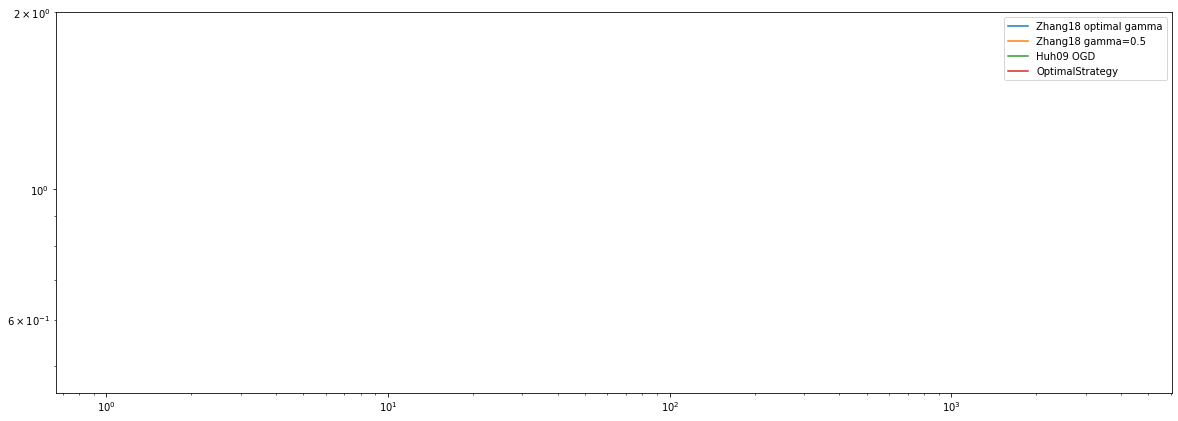

In [ ]:
plt.figure(figsize=(20,7))
for policy_id in range(len(policies)) :
    x_ = np.arange(1,nb_periods+1)
    y_ = np.array(
        pd.read_csv("inventory_movements/{}/movements_{}.csv".format(experiment_name,policy_id))
        .groupby("period")
        ["interim_inventory_level"]
        .sum()
        .loc[1:nb_periods]
        .pipe(expected_instantaneous_cost)
        .expanding()
        .mean()
    )
    plt.loglog(x_,y_,label=str(policies[policy_id]))
    if(str(policies[policy_id]) == "OptimalStrategy") :
        band_ = 1/np.sqrt(x_)
        plt.fill_between(x_,y_-band_,y_+band_,alpha=0.1,color="purple")
plt.ylim((0.45,2))
plt.legend()
plt.show()

### Average of expected costs compared to $S^*$
$$
T\mapsto \frac{1}{T}\sum_{t=1}^T Q(y_t)-Q(S^*)
$$

In [ ]:
opt_ = np.array(
        pd.read_csv("inventory_movements/{}/movements_{}.csv".format(experiment_name, 5))
        .groupby("period")
        ["interim_inventory_level"]
        .sum()
        .loc[1:nb_periods]
        .pipe(expected_instantaneous_cost)
        .expanding()
        .mean()
    )
plt.figure(figsize=(20,7))
for policy_id in range(len(policies)) :
    x_ = np.arange(1,nb_periods+1)
    if(str(policies[policy_id]) == "OptimalStrategy") :
        band_ = 1/np.sqrt(x_)
        plt.fill_between(x_,0,band_,alpha=0.1,color="purple")
    
    else :
        y_ = np.array(
            pd.read_csv("inventory_movements/{}/movements_{}.csv".format(experiment_name, policy_id))
            .groupby("period")
            ["interim_inventory_level"]
            .sum()
            .loc[1:nb_periods]
            .pipe(expected_instantaneous_cost)
            .expanding()
            .mean()
        )
        plt.semilogx(x_,y_-opt_,label=str(policies[policy_id]))
plt.ylim((-0.1,0.4))
plt.legend()
plt.show()

ValueError: operands could not be broadcast together with shapes (4000,) (2001,) 

<Figure size 1440x504 with 0 Axes>